# 数据获取与预处理

## 数据获取

#### 导入完成作业用的第三方库

In [1]:
import tushare as ts
import akshare as ak
from opendatatools import stock
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import scipy
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
hxgf_ts=ts.get_k_data('300427',"2020-01-06","2023-04-01",ktype="D")
hxgf_od=stock.get_daily("300427.SZ","2020-01-06","2023-04-01")
hxgf_od=hxgf_od[0]
hxgf_ak=ak.stock_zh_a_hist(symbol="300427",start_date="20200106",end_date="20230401")

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


C:\Users\20392\AppData\Roaming\Python\Python39\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,
C:\Users\20392\AppData\Roaming\Python\Python39\site-packages\tushare\stock\trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


#### 数据清洗

In [5]:
print(hxgf_ts.isna().sum())

date      0
open      0
close     0
high      0
low       0
volume    0
code      0
dtype: int64


In [6]:
print(hxgf_od.isna().sum())

symbol           0
time             0
volume           0
open             0
high             0
low              0
last             0
change           0
percent          0
turnover_rate    0
dtype: int64


In [7]:
print(hxgf_ak.isna().sum())

日期     0
开盘     0
收盘     0
最高     0
最低     0
成交量    0
成交额    0
振幅     0
涨跌幅    0
涨跌额    0
换手率    0
dtype: int64


## 绘图与统计分析

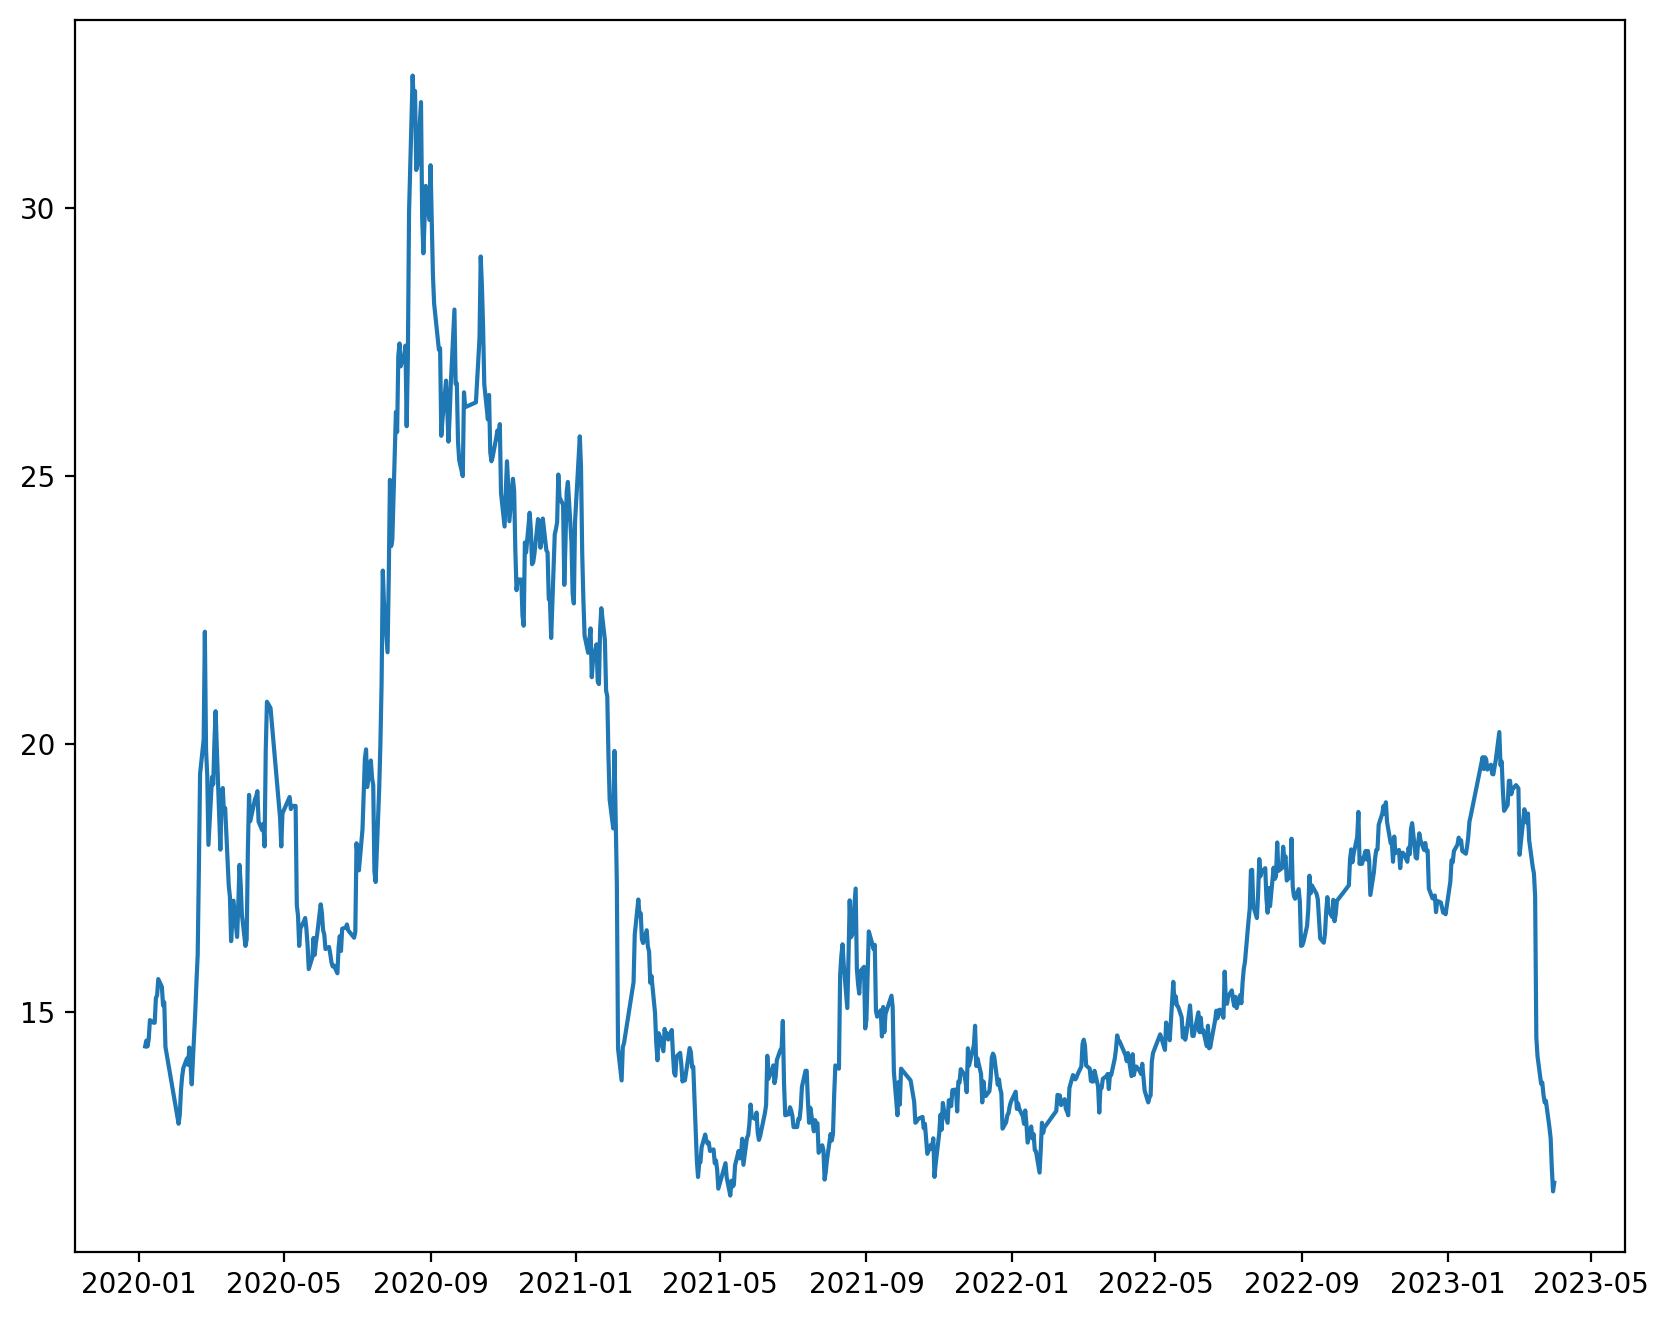

In [8]:
fig=plt.figure(figsize=(10,8),dpi=200)
plt.plot(hxgf_od['time'],hxgf_od['last'])

#### 数据的描述性统计

In [9]:
hxgf_od.describe()

,volume,open,high,low,last,change,percent,turnover_rate
count,7.800000e+02,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000,780.000000
mean,7.782290e+06,17.138085,17.541238,16.768191,17.143992,-0.003199,0.026218,2.645013
std,6.722923e+06,4.312601,4.486642,4.151819,4.300175,0.595655,3.185402,2.537396
min,9.215970e+05,10.650000,11.880000,10.650000,11.572000,-3.098400,-17.790000,0.280000
25%,3.723352e+06,13.817500,14.115000,13.607500,13.837500,-0.277200,-1.710000,1.140000
50%,5.571418e+06,16.234900,16.610300,16.000000,16.260000,0.010000,0.060000,1.830000
75%,9.261322e+06,18.665025,19.113875,18.161075,18.700000,0.250000,1.545000,3.070000
max,6.238866e+07,32.063000,34.310000,31.449200,32.468800,2.722300,12.550000,24.490000


#### 数据的正态性检验

In [10]:
data=hxgf_od['last']
statistic,p=scipy.stats.normaltest(data, axis=0, nan_policy='propagate')

In [11]:
statistic 

145.4001968367572

In [12]:
p

2.6714584451812345e-32

## 构建单一指数模型

In [13]:
szzs=ak.stock_zh_index_daily(symbol='sz399001')
hxgf_od.set_index(hxgf_od['time'],inplace=True)
szzs['date']=pd.to_datetime(szzs['date'])
szzs.set_index(szzs['date'],inplace=True)
hxgf_od['pt-1']=hxgf_od['last'].shift(1)
hxgf_od['return1']=(hxgf_od['last']-hxgf_od['pt-1'])/hxgf_od['pt-1']
hxgf_od.drop(index='2020-01-06',inplace=True)
szzs['pt-1']=szzs['close'].shift(1)
szzs['return2']=(szzs['close']-szzs['pt-1'])/szzs['pt-1']
szzs_model=szzs.loc[hxgf_od['time']]
model_y=hxgf_od['return1']
model_x=szzs_model['return2']
model=pd.concat([hxgf_od['return1'],szzs_model['return2']],axis=1)

#### 计算相关系数矩阵

In [14]:
model.corr()

,return1,return2
return1,1.000000,0.443853
return2,0.443853,1.000000


#### 绘制散点图

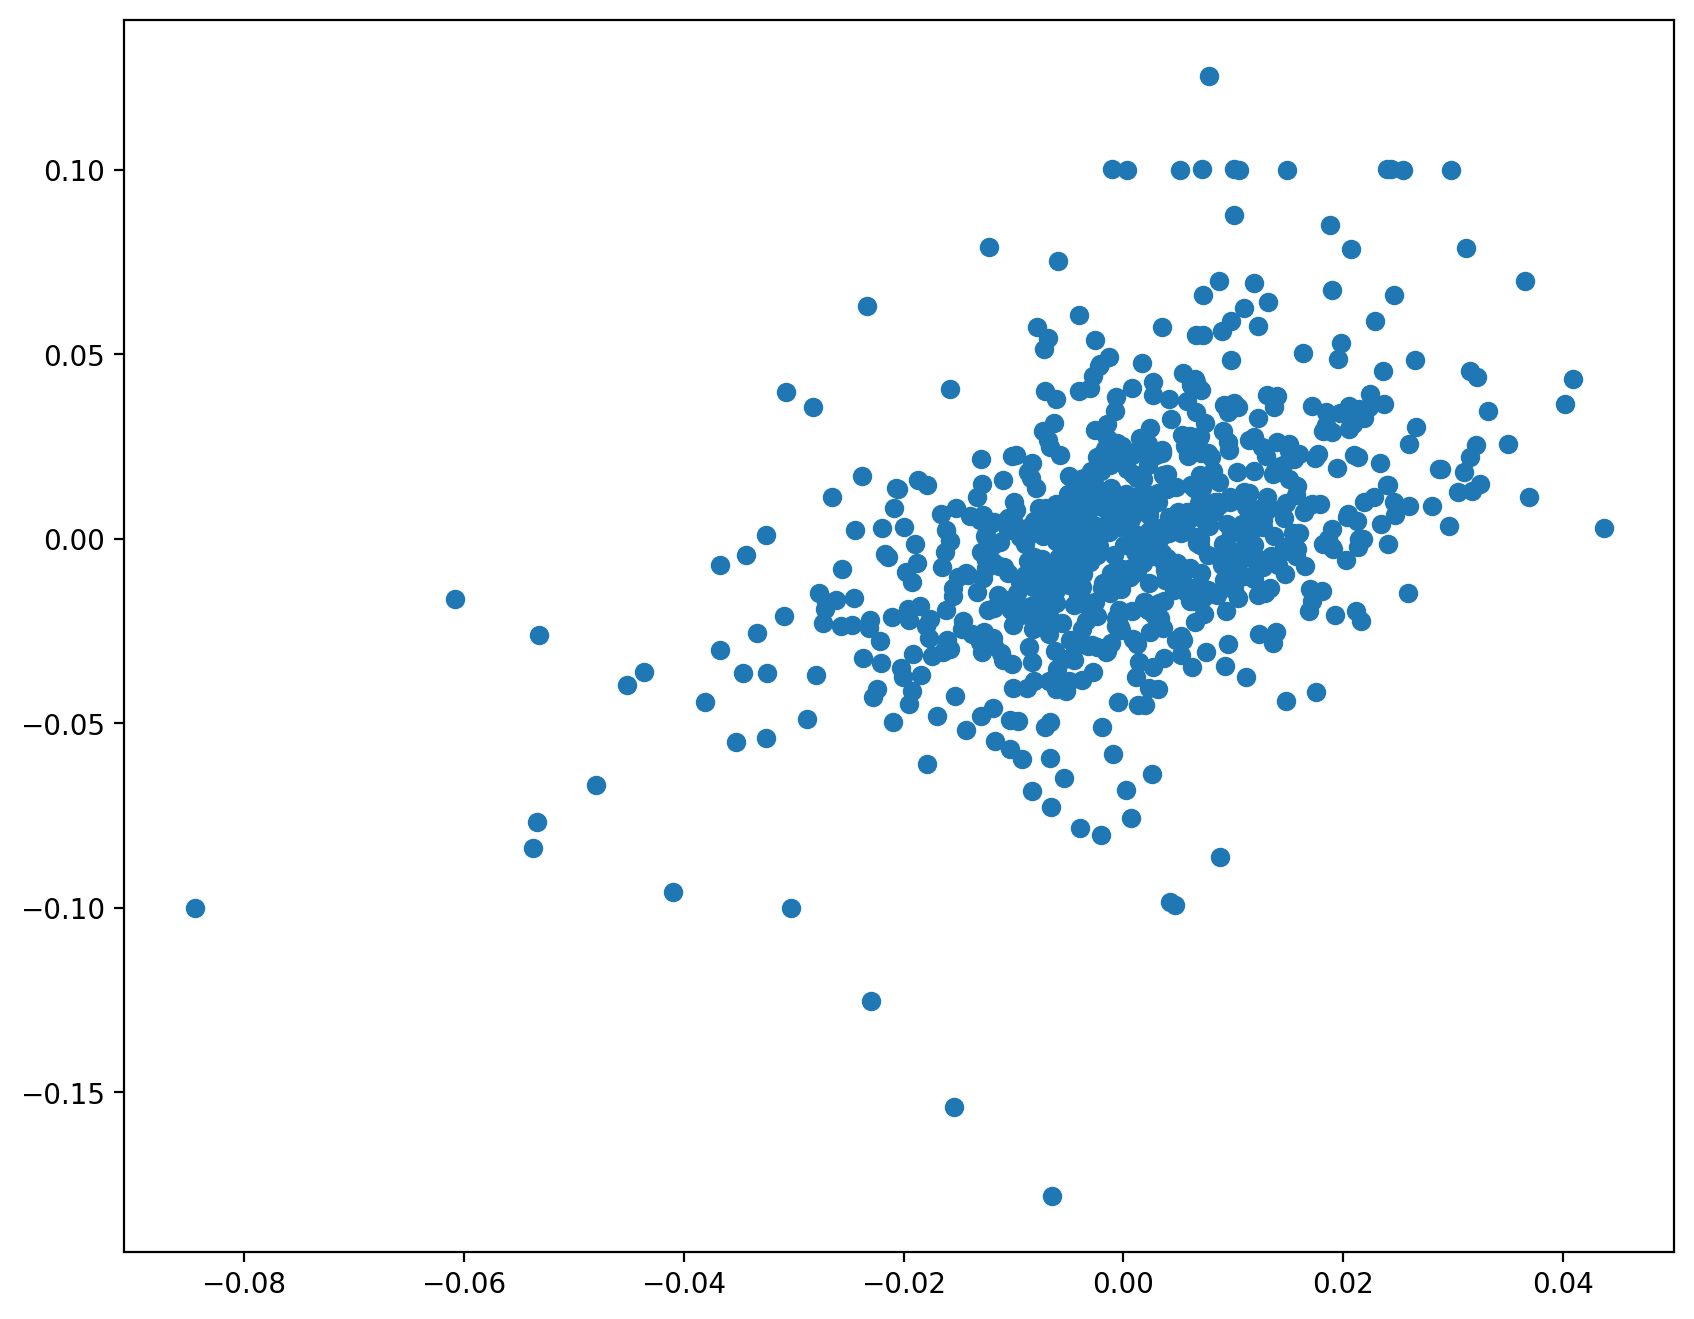

In [15]:
fig=plt.figure(figsize=(10,8),dpi=200)
plt.scatter(model_x,model_y)

### 进行线性回归，构建单指数模型

#### 含趋势项回归

In [16]:
results = smf.ols('return1 ~ return2 ', data=model).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                return1   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     190.6
Date:                Tue, 11 Apr 2023   Prob (F-statistic):           6.14e-39
Time:                        21:37:17   Log-Likelihood:                 1665.0
No. Observations:                 779   AIC:                            -3326.
Df Residuals:                     777   BIC:                            -3317.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.117e-05      0.001      0.021      0.9

#### 无趋势项回归

In [17]:
results1 = smf.ols('return1 ~ 0+return2 ', data=model).fit()
print(results1.summary())

                                 OLS Regression Results                                
Dep. Variable:                return1   R-squared (uncentered):                   0.197
Model:                            OLS   Adj. R-squared (uncentered):              0.196
Method:                 Least Squares   F-statistic:                              190.9
Date:                Tue, 11 Apr 2023   Prob (F-statistic):                    5.36e-39
Time:                        21:37:17   Log-Likelihood:                          1665.0
No. Observations:                 779   AIC:                                     -3328.
Df Residuals:                     778   BIC:                                     -3323.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

### 残差分析与模型检验

#### 绘制残差序列图

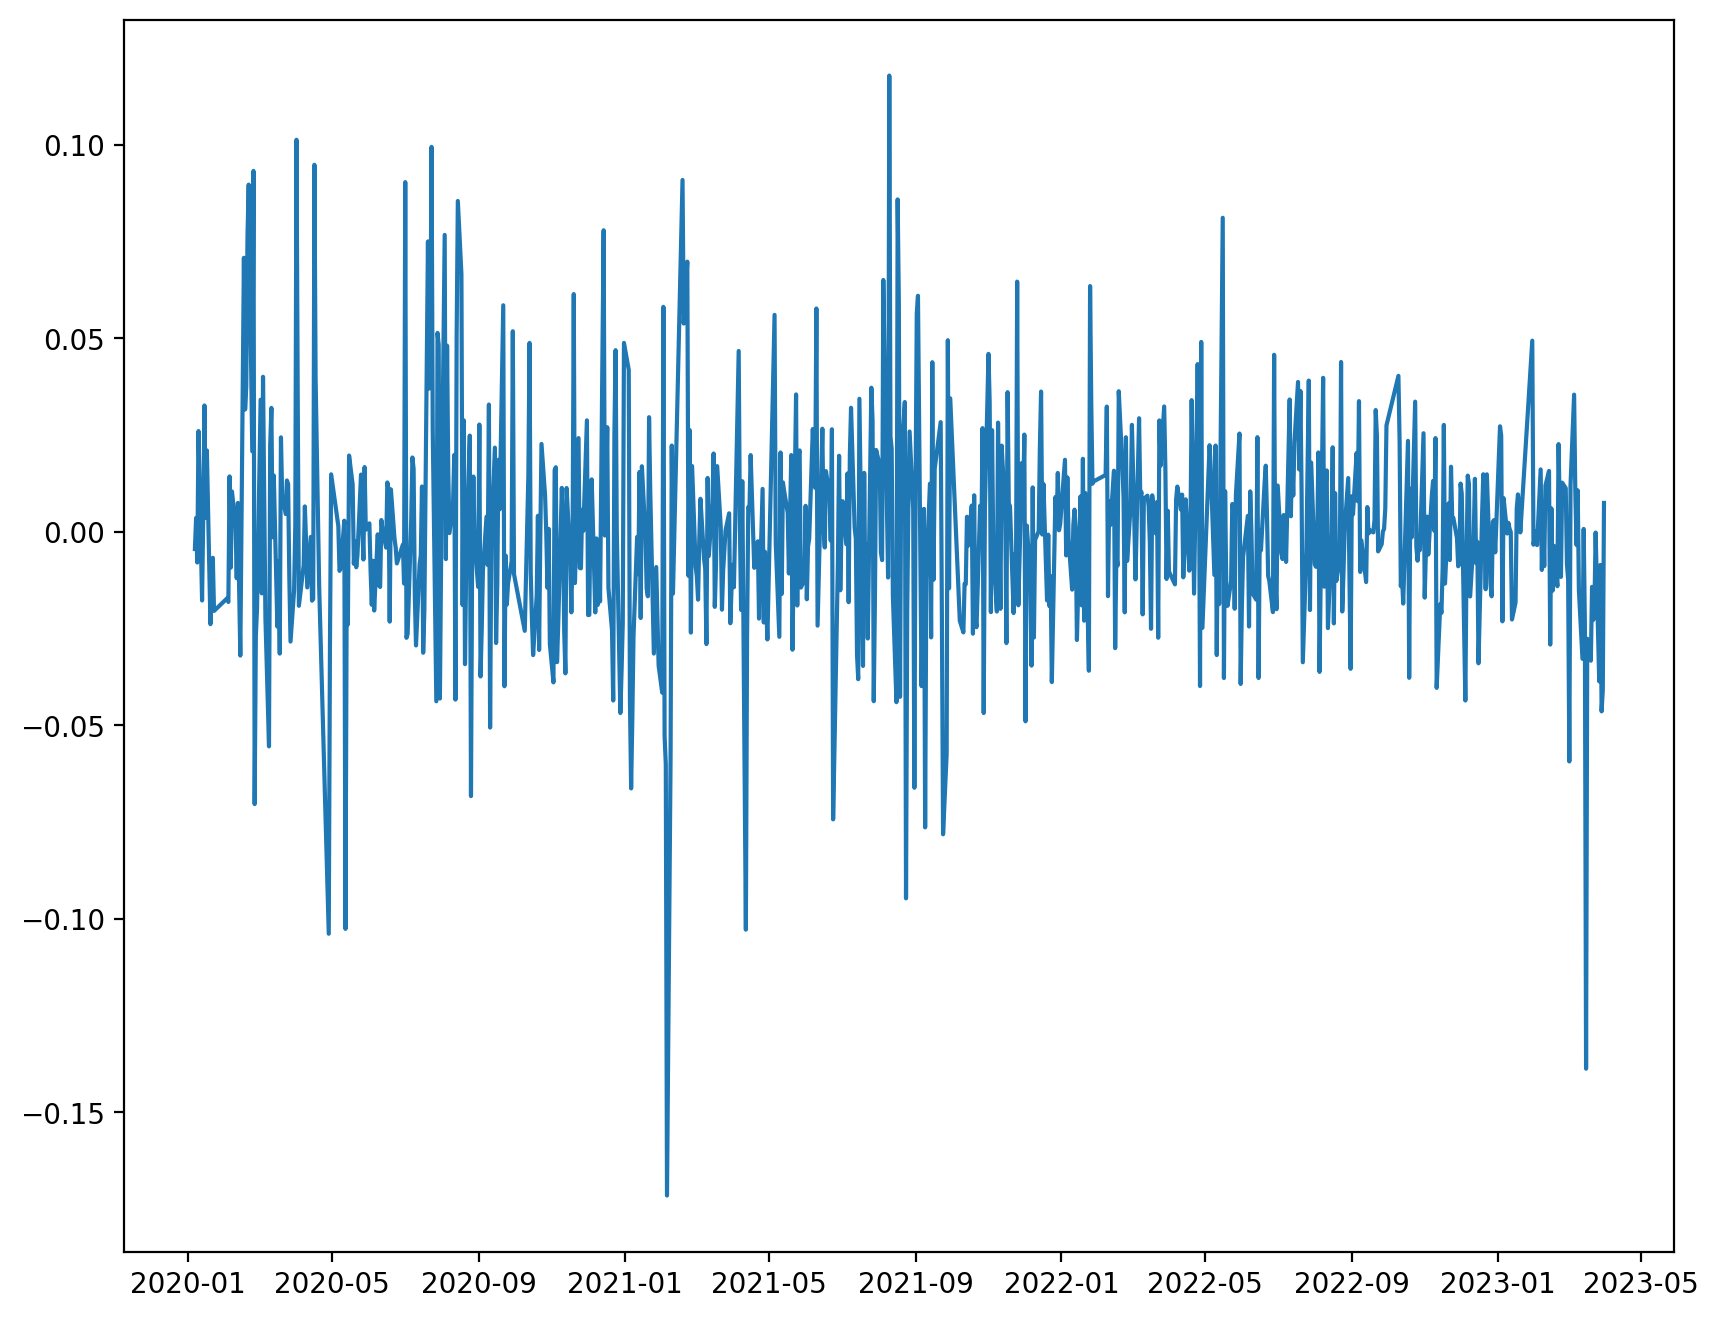

In [18]:
redus=model_y-results1.predict(model_x)
fig=plt.figure(figsize=(10,8),dpi=200)
plt.plot(redus)

#### 绘制残差序列自相关图
- 残差序列为白噪声序列，模型拟合充分

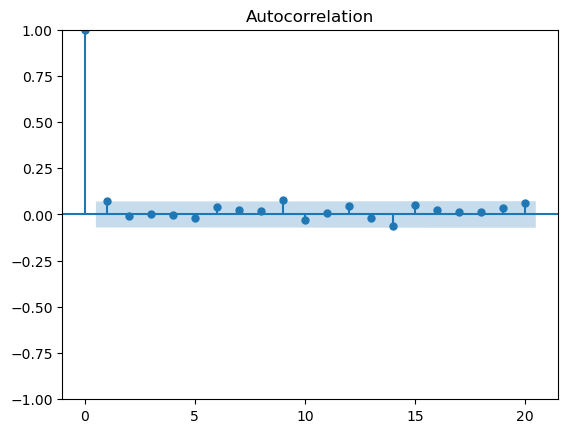

In [19]:
plot_acf(redus,lags=20);

#### 对残差进行BOX-Ljung检验

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
ljungbox_result = acorr_ljungbox(redus, lags=20)  # 返回统计量和p值，lags为检验的延迟数

In [21]:
ljungbox_result

,lb_stat,lb_pvalue
1,3.902136,0.048225
2,3.988090,0.136144
3,3.990185,0.262526
4,3.991015,0.407223
5,4.340605,0.501489
6,5.646646,0.463913
7,6.176395,0.519310
8,6.516852,0.589539
9,11.171939,0.264107
10,11.882386,0.293005


# 作业简述

## 比较分析各种方法所获取股票的差异
- 函数的调用方式不同，主要表现在日期格式的指定和股票代码
- 函数返回值不同
    - 三者返回的数据精度并不是完全一样的。其中精度最高的是利用opendatatools获取的数据，最低的是akshare获取的数据
    - 数据的返回类型不。tushare和akshare返回的数据类型都是Dataframe，只有利用opendatatools获取的数据是元组类型
    - 三者数据的值不同。即使是同一天，三者返回的值结果也不完全一样，存在一定的差异，以2020-01-02的数据来看，三者开盘价依次为13.928，14.19，13.9325。
    - 三者返回的股票数据量不同。tushare返回的股票数据字段最少，akshare和opeandatatools返回数据都包括涨跌额、涨跌幅以及换手率等数据，akshare返回的数据还多一个振幅字段

## 构建单指数模型，测度所选取股票风险
- β系数是衡量股票收益相对于业绩评价基准收益的总体波动性的指标，用于衡量系统性风险。红相股份β值为0.9797，表明红相股份的收益和风险小于深圳成分指数的收益与风险来说

In [6]:
szzs=ak.stock_zh_index_daily(symbol='sh000001')

szzs['date']=pd.to_datetime(szzs['date'])

szzs.set_index(szzs['date'],inplace=True)

df=szzs.loc["2017-01-01":"2022-01-01",:]
df.to_csv("2017-2022上证指数.csv",encoding="utf-8")